In [1]:
import pandas as pd
import numpy as np
import glob
import os
import sys

# Verificamos dónde estamos
current_dir = os.getcwd()
print(f"Directorio actual: {current_dir}")

# Intentamos añadir la carpeta superior al path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# Comprobación de seguridad: Si 'src' está en la misma carpeta, añadimos la actual también
sys.path.append(current_dir)

try:
    from src.config import INVALID_PRICES, VALID_STATUS_CODES, VENUES
    print("✅ Importación exitosa desde src.config")
except ModuleNotFoundError:
    print("❌ Fallo")

DATA_PATH = r"../data/DATA_BIG" 

Directorio actual: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\notebooks
✅ Importación exitosa desde src.config


### Ingesta, Limpieza y Sincronización de Microestructura

En este bloque se implementa la lógica crítica para procesar los datos crudos del proveedor. Se definen dos funciones encargadas de transformar los archivos CSV en información operativa fiable:

* **`load_and_clean_venue_data`**: Procesa un mercado individual aplicando tres filtros de calidad basados en las especificaciones del proveedor:
    * **Filtrado de "Magic Numbers":** Elimina precios sintéticos (como `999,999.999`) que representan órdenes de mercado o estados no operables.
    * **Sincronización de Estados (STS):** Utiliza `pd.merge_asof` (con dirección *backward*) para cruzar asíncronamente las cotizaciones (QTE) con los estados del mercado (STS). Esto permite asignar a cada tick su estado de mercado vigente exacto.
    * **Filtro de "Continuous Trading":** Descarta cualquier cotización que ocurra durante subastas, paradas o cierres, manteniendo solo aquellas válidas para arbitraje inmediato (según los códigos válidos definidos en la documentación).

*  **`load_all_venues_for_isin`**: Función que itera sobre todos los mercados disponibles (BME, AQUIS, CBOE, TURQUOISE), ejecuta la limpieza anterior y consolida los resultados en un único DataFrame vertical (*Long Format*) ordenado temporalmente.

La estructrua del dataframe esperado tras este paso debe ser algo asi:
| epoch (Tiempo) | venue | px_bid_0 | qty_bid_0 | px_ask_0 | qty_ask_0 | market_trading_status |
|----------------|-------|----------|-----------|----------|-----------|------------------------|
| 170000000001   | BME   | 10.50    | 500       | 10.52    | 200       | Open                   |
| 170000000002   | AQUIS | 10.49    | 1000      | 10.53    | 600       | Open                   |
| 170000000005   | BME   | 10.51    | 300       | 10.52    | 150       | Open                   |
| 170000000008   | CBOE  | 10.50    | 2000      | 10.51    | 500       | Open                   |


In [17]:
# Mapping de nombres
MIC_MAPPING = {
    "BME": "XMAD",
    "AQUIS": "AQEU",
    "CBOE": "CEUX",      
    "TURQUOISE": "TQEX"  
}

def load_and_clean_venue_data(data_path, date, isin, venue_name):
    file_mic = MIC_MAPPING.get(venue_name, venue_name)
    
    # Construcción de rutas (Estrategia doble: carpeta anidada o plana)
    path_v1 = os.path.join(data_path, f"{venue_name}_{date}") # DATA/VENUE_DATE/
    path_v2 = data_path                                        # DATA/
    
    qte_name = f"QTE_{date}_{isin}_*_{file_mic}_*.csv.gz"
    sts_name = f"STS_{date}_{isin}_*_{file_mic}_*.csv.gz"
    
    # Búsqueda de archivos
    qte_files = glob.glob(os.path.join(path_v1, qte_name)) or glob.glob(os.path.join(path_v2, qte_name))
    sts_files = glob.glob(os.path.join(path_v1, sts_name)) or glob.glob(os.path.join(path_v2, sts_name))
    
    if not qte_files or not sts_files:
        return None

    # --- LECTURA ---
    try:
        # Intentamos leer primero con coma (estándar)
        df_qte = pd.read_csv(qte_files[0], compression='gzip', sep=',')
        
        # Si leemos y solo hay 1 columna, es sospechoso, por lo que probamos con punto y coma
        if len(df_qte.columns) < 2:
            df_qte = pd.read_csv(qte_files[0], compression='gzip', sep=';')
            
        # Hacemos lo mismo para el STS
        df_sts = pd.read_csv(sts_files[0], compression='gzip', sep=',')
        if len(df_sts.columns) < 2:
            df_sts = pd.read_csv(sts_files[0], compression='gzip', sep=';')
            
        # Limpieza de nombres de columnas (quita espacios extra tipo " epoch")
        df_qte.columns = df_qte.columns.str.strip()
        df_sts.columns = df_sts.columns.str.strip()
        
        # Si la columna clave no está, lanzamos error informativo
        if 'px_bid_0' not in df_qte.columns:
            raise ValueError(f"Columnas encontradas: {list(df_qte.columns)}. Falta 'px_bid_0'.")

    except Exception as e:
        print(f"  ⚠️ Error leyendo archivo de {venue_name}: {e}")
        return None
    
    # --- LIMPIEZA A: MAGIC NUMBERS ---
    for price in INVALID_PRICES:
        if 'px_bid_0' in df_qte.columns and 'px_ask_0' in df_qte.columns:
            mask_invalid = np.isclose(df_qte['px_bid_0'], price) | np.isclose(df_qte['px_ask_0'], price)
            df_qte = df_qte[~mask_invalid]
    
    # --- LIMPIEZA B: MARKET STATUS ---
    df_qte = df_qte.sort_values('epoch')
    df_sts = df_sts.sort_values('epoch')
    
    df_merged = pd.merge_asof(
        df_qte, 
        df_sts[['epoch', 'market_trading_status']], 
        on='epoch', 
        direction='backward'
    )
    
    if venue_name not in VALID_STATUS_CODES:
        valid_codes = []
    else:
        valid_codes = VALID_STATUS_CODES[venue_name]
    
    df_clean = df_merged[df_merged['market_trading_status'].isin(valid_codes)].copy()
    df_clean['venue'] = venue_name 
    
    cols_to_keep = ['epoch', 'venue', 'px_bid_0', 'qty_bid_0', 'px_ask_0', 'qty_ask_0', 'market_trading_status']
    # Aseguramos que existan las columnas antes de filtrar
    existing_cols = [c for c in cols_to_keep if c in df_clean.columns]
    return df_clean[existing_cols]

def load_all_venues_for_isin(data_path, date, isin):
    all_data = []
    print(f"Iniciando carga para {isin} en {date}...")
    print(f"Ruta base: {os.path.abspath(data_path)}")
    
    for venue in VENUES:
        df_venue = load_and_clean_venue_data(data_path, date, isin, venue)
        
        if df_venue is not None and not df_venue.empty:
            all_data.append(df_venue)
            print(f"  ✅ {venue}: Cargados {len(df_venue)} ticks.")
        else:
            print(f"  ❌ {venue}: No se encontraron datos válidos.")
            
    if not all_data:
        return pd.DataFrame()
        
    full_df = pd.concat(all_data, ignore_index=True)
    full_df = full_df.sort_values('epoch')
    return full_df

### Validación de Ingesta 

Antes de proceder a la construcción del *Consolidated Tape*, es fundamental validar que el proceso ETL (Extracción, Transformación y Carga) funciona correctamente sobre una muestra controlada.

En este bloque ejecutamos una prueba unitaria con un activo (ISIN), en este caso GRIFOLS y fecha específicos para verificar:

1.  **Integridad de los datos:** Confirmar que la función de carga cruza correctamente los ficheros de precios (QTE) y estados (STS) sin generar errores de ejecución.
2.  **Fragmentación visible:** Comprobar que, efectivamente, recuperamos datos de múltiples centros de negociación (*Venues*) para el mismo activo, condición necesaria para que exista arbitraje.
3.  **Volumen de datos:** Verificar que los filtros de calidad (como la eliminación de *Magic Numbers*) no están descartando la totalidad de la muestra y que obtenemos un número razonable de ticks.

In [18]:
# Configuramos un caso real, el de GRIFOLS, que está en nuestras carpetas
TEST_DATE = "2025-11-07" 
TEST_ISIN = "ES0171996087" 

try:
    df_ticks = load_all_venues_for_isin(DATA_PATH, TEST_DATE, TEST_ISIN)
    
    if not df_ticks.empty:
        print("\n¡ÉXITO! Datos cargados y limpios:")
        print(df_ticks.head())
        print(f"\nTotal de ticks procesados: {len(df_ticks)}")
        print("Venues encontrados:", df_ticks['venue'].unique())
    else:
        print("\nNo se encontraron datos. Verifica PATH, FECHA e ISIN.")
except Exception as e:
    print(f"Error durante la ejecución: {e}")

Iniciando carga para ES0171996087 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 44144 ticks.
  ✅ AQUIS: Cargados 17481 ticks.
  ✅ CBOE: Cargados 20912 ticks.
  ✅ TURQUOISE: Cargados 7435 ticks.

¡ÉXITO! Datos cargados y limpios:
                  epoch      venue  px_bid_0  qty_bid_0  px_ask_0  qty_ask_0  \
44144  1762502417476028      AQUIS    10.275      621.0       NaN        NaN   
44145  1762502417476039      AQUIS    10.275      621.0    10.485      621.0   
82537  1762502417500397  TURQUOISE    10.300        5.0       NaN        NaN   
82538  1762502417500693  TURQUOISE    10.330      311.0       NaN        NaN   
82539  1762502417500708  TURQUOISE    10.330      311.0    10.430      311.0   

       market_trading_status  
44144              5308427.0  
44145              5308427.0  
82537              7608181.0  
82538              7608

### Construcción del "Virtual Consolidated Tape"

Para detectar arbitraje, es necesario comparar los precios de todos los centros de negociación (*Venues*) en el mismo instante exacto. Sin embargo, los datos originales llegan como eventos asíncronos (una fila por cada actualización de un solo mercado).

En este bloque transformamos los datos al formato necesario para el análisis:

1.  **Pivotaje (Wide Format):** Reestructuramos el DataFrame para que el índice sea el tiempo (`epoch`) y las columnas representen los precios (*Bid/Ask*) y volúmenes de cada mercado simultáneamente.
2.  **Alineación Temporal (`Forward Fill`):** Dado que los mercados no se actualizan al unísono, utilizamos la técnica de `ffill`. Esto asume que el último precio conocido de un mercado sigue vigente hasta que llega una nueva actualización, simulando la visión persistente que tendría un *Smart Order Router* (SOR) en tiempo real.

| Tiempo | Evento Real              | ¿Qué ve Pandas sin ffill?      | ¿Qué ve Pandas CON ffill?        |
|--------|---------------------------|----------------------------------|-----------------------------------|
| T=1    | BME cambia a 10€          | BME=10, CBOE=NaN                 | BME=10, CBOE=9.98 (del pasado)    |
| T=2    | (Nadie hace nada)         | BME=NaN, CBOE=NaN                | BME=10, CBOE=9.98                 |
| T=3    | CBOE cambia a 9.99€       | BME=NaN, CBOE=9.99               | BME=10, CBOE=9.99                 |

3.  **Limpieza:** Se eliminan los instantes iniciales donde no todos los mercados han cotizado aún, garantizando que siempre comparamos precios completos.

| Tiempo | Evento Real              | Estado del Tape (Lo que ve Python)                   | Acción de Limpieza (dropna)                   |
|--------|---------------------------|-------------------------------------------------------|------------------------------------------------|
| T=1    | BME abre a 10.00€         | BME=10.00, AQUIS=NaN, CBOE=NaN                        | 🗑️ BORRAR (Faltan 2 mercados)                  |
| T=2    | AQUIS abre a 10.01€       | BME=10.00, AQUIS=10.01, CBOE=NaN                      | 🗑️ BORRAR (Falta CBOE)                         |
| T=3    | (Silencio)                | BME=10.00, AQUIS=10.01, CBOE=NaN                      | 🗑️ BORRAR (Sigue faltando CBOE)               |
| T=4    | CBOE abre a 9.99€         | BME=10.00, AQUIS=10.01, CBOE=9.99                     | ✅ MANTENER (¡Ya están todos!)                 |
| T=5    | BME sube a 10.02€         | BME=10.02, AQUIS=10.01, CBOE=9.99                     | ✅ MANTENER                                    |


In [19]:
def build_consolidated_tape(df_all_venues):

    if df_all_venues.empty:
        return pd.DataFrame()
    
    # 1. Pivotar: Convertimos VENUES en COLUMNAS
    # Usamos 'last' por si hay múltiples actualizaciones en el mismo microsegundo exacto
    tape = df_all_venues.pivot_table(
        index='epoch', 
        columns='venue', 
        values=['px_bid_0', 'px_ask_0', 'qty_bid_0', 'qty_ask_0'],
        aggfunc='last' 
    )
    
    # 2. Alineación temporal (ffill)
    tape = tape.ffill()
    
    # 3. Limpieza 
    tape = tape.dropna()
    
    # 4. Aplanar nombres de columnas 
    # Ejemplo transformación: ('px_bid_0', 'BME') -> 'BME_px_bid_0'
    tape.columns = [f"{col[1]}_{col[0]}" for col in tape.columns]
    
    return tape

# --- EJECUCIÓN ---
try:
    print("Construyendo el Consolidated Tape...")
    
    # Usamos el df_ticks que cargaste exitosamente en el paso anterior
    consolidated_tape = build_consolidated_tape(df_ticks)
    
    print(f"Dimensiones: {consolidated_tape.shape}")
    print("Primeras 5 filas (Precios alineados de todos los mercados):")
    display(consolidated_tape.head()) 
    
except Exception as e:
    print(f"Error creando el tape: {e}")

Construyendo el Consolidated Tape...
Dimensiones: (86744, 16)
Primeras 5 filas (Precios alineados de todos los mercados):


,AQUIS_px_ask_0,BME_px_ask_0,CBOE_px_ask_0,TURQUOISE_px_ask_0,AQUIS_px_bid_0,BME_px_bid_0,CBOE_px_bid_0,TURQUOISE_px_bid_0,AQUIS_qty_ask_0,BME_qty_ask_0,CBOE_qty_ask_0,TURQUOISE_qty_ask_0,AQUIS_qty_bid_0,BME_qty_bid_0,CBOE_qty_bid_0,TURQUOISE_qty_bid_0
epoch,,,,,,,,,,,,,,,,
1762502419492911,10.47,10.395,10.425,10.43,10.37,10.365,10.37,10.37,621.0,422.0,205.0,311.0,286.0,346.0,116.0,46.0
1762502419513599,10.47,10.395,10.425,10.43,10.37,10.365,10.37,10.37,621.0,210.0,205.0,311.0,286.0,346.0,116.0,46.0
1762502419517827,10.47,10.395,10.425,10.43,10.37,10.365,10.37,10.37,621.0,210.0,205.0,311.0,286.0,346.0,116.0,46.0
1762502419517828,10.47,10.395,10.425,10.43,10.37,10.365,10.37,10.37,621.0,210.0,205.0,311.0,286.0,346.0,116.0,46.0
1762502419517831,10.47,10.395,10.425,10.43,10.37,10.365,10.37,10.37,621.0,210.0,205.0,311.0,286.0,346.0,116.0,46.0


**OBSERVACIÓN**

Para este estudio se ha utilizado una agregación por microsegundo (aggfunc='last') para optimizar el rendimiento computacional en el escaneo de 195 activos. Soy consciente de que, en entornos de producción HFT, esto implica una pérdida de información en momentos de alta volatilidad donde ocurren múltiples eventos en el mismo microsegundo. Una implementación futura ideal incluiría la técnica de 'Nanosecond Offset' para no perder ninguna oportunidad por fugaz que sea y que la agregación actual podría enmascarar.

### Motor de Detección de Oportunidades (Signal Generation)

Una vez construido el *Consolidated Tape*, procedemos a identificar instantes donde se viola la eficiencia del mercado, es decir, cuando el precio de compra en un mercado supera al precio de venta en otro.

Se implementan las siguientes reglas de negocio:

1.  **Best Bid/Offer Global:** Para cada *epoch*, calculamos el precio máximo de compra (*Max Bid*) y el precio mínimo de venta (*Min Ask*) disponibles entre todos los *venues*.
2.  **Cálculo del Spread:** Definimos el beneficio potencial bruto por acción como `Spread = Max_Bid - Min_Ask`. Un spread positivo indica una oportunidad de arbitraje.
3.  **Detección de Flancos (*Rising Edge*):** Para evitar contar la misma oportunidad múltiples veces mientras persiste, aplicamos un filtro de "flanco de subida". Solo generamos una señal de entrada en el instante exacto en que la condición de arbitraje pasa de `False` a `True`.
4.  **Cálculo de Beneficio Teórico:** Estimamos el P&L (Ganancia y Pérdida) asumiendo ejecución inmediata (Latencia 0) y tomando el volumen mínimo disponible entre la orden de compra y la de venta (`min(Qty_Bid, Qty_Ask)`).

**Descripción de las funciones implementadas:**

* **`get_best_prices_and_volumes`:** Actúa como un escáner de precios. Recorre horizontalmente el *Consolidated Tape* para identificar, en cada microsegundo, cuál es el mejor precio de compra y de venta global, registrando además el mercado (*Venue*) de origen.
* **`find_arbitrage_opportunities`:** Ejecuta la lógica financiera. Calcula el *spread*, aplica el filtro de *Rising Edge* para aislar el inicio de la oportunidad y computa el beneficio teórico cruzando el spread con el volumen ejecutable real (`qty_tradeable`).

In [20]:
def get_best_prices_and_volumes(tape):
    # Creamos dos listas con los nombres de las columnas
    bid_cols = [c for c in tape.columns if 'px_bid_0' in c]
    ask_cols = [c for c in tape.columns if 'px_ask_0' in c]
    
    # Calculamos Max Bid y Min Ask, fila a fila
    tape['best_bid_price'] = tape[bid_cols].max(axis=1)
    tape['best_ask_price'] = tape[ask_cols].min(axis=1)
    
    # Identificamos qué mercado tiene ese precio (ej: 'BME_px_bid_0')
    tape['best_bid_col'] = tape[bid_cols].idxmax(axis=1)
    tape['best_ask_col'] = tape[ask_cols].idxmin(axis=1)
    
    # Extraer el nombre limpio del venue (en lugar de darnos 'BME_px_bid_0', nos da 'BME')
    tape['best_bid_venue'] = tape['best_bid_col'].str.split('_').str[0]
    tape['best_ask_venue'] = tape['best_ask_col'].str.split('_').str[0]
    
    return tape

def find_arbitrage_opportunities(tape):
    # Enriquecer con mejores precios
    tape = get_best_prices_and_volumes(tape)
    
    # Calcular Spread
    tape['spread'] = tape['best_bid_price'] - tape['best_ask_price']
    
    # Si el spread es positivo se muestra como una oportunidad de arbitraje
    tape['is_arbitrage'] = tape['spread'] > 0
    
    # En esta linea marcamos que entramos si la oportunidad de arbitraje ahora es TRUE y antes era FALSE
    tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
    
    # Filtrar solo los momentos de entrada
    opportunities = tape[tape['entry_signal']].copy()
    
    if opportunities.empty:
        return opportunities

    # Cálculo del Beneficio Teórico en Latencia 0
    
    # Preparamos el nombre de la columna de volumen. Si el mejor precio estaba en BME_px_bid_0, sabemos que el volumen estará en BME_qty_bid_0
    opportunities['bid_qty_col'] = opportunities['best_bid_col'].str.replace('px', 'qty')
    opportunities['ask_qty_col'] = opportunities['best_ask_col'].str.replace('px', 'qty')
    
    # --- EXTRACCIÓN SEGURA DE VOLÚMENES (Corrección del error) ---
    # Usamos listas por comprensión, que es más seguro que apply en este contexto
    qty_bids = []
    qty_asks = []
    
    # Iteramos fila por fila sobre las oportunidades
    for idx, row in opportunities.iterrows():
        # Coge el nombre de la fila row
        qty_bids.append(row[row['bid_qty_col']])
        qty_asks.append(row[row['ask_qty_col']])
    
    opportunities['qty_bid'] = qty_bids
    opportunities['qty_ask'] = qty_asks
    # -------------------------------------------------------------
    
    # Cantidad ejecutable es el mínimo de las dos puntas. Compro el valor menor que esté en vente
    opportunities['qty_tradeable'] = opportunities[['qty_bid', 'qty_ask']].min(axis=1)
    
    # Beneficio = Spread * Cantidad
    opportunities['profit_theoretical'] = opportunities['spread'] * opportunities['qty_tradeable']
    
    return opportunities

# --- EJECUCIÓN ---
try:
    print("Buscando oportunidades de arbitraje...")
    opps = find_arbitrage_opportunities(consolidated_tape)
    
    print(f"\n¡ANÁLISIS TERMINADO!")
    print(f"Oportunidades encontradas: {len(opps)}")
    
    if not opps.empty:
        total_theo = opps['profit_theoretical'].sum()
        print(f"Beneficio Total Teórico (Latencia 0): {total_theo:.2f} €")
        print("\nEjemplo de operaciones detectadas:")
        cols_show = ['best_bid_venue', 'best_ask_venue', 'spread', 'qty_tradeable', 'profit_theoretical']
        display(opps[cols_show].head())
    else:
        print("No se encontraron oportunidades. El mercado parece eficiente.")
        
except Exception as e:
    print(f"Error en detección: {e}")

Buscando oportunidades de arbitraje...

¡ANÁLISIS TERMINADO!
Oportunidades encontradas: 25
Beneficio Total Teórico (Latencia 0): 23.45 €

Ejemplo de operaciones detectadas:


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


,best_bid_venue,best_ask_venue,spread,qty_tradeable,profit_theoretical
epoch,,,,,
1762502420565157,CBOE,BME,0.010,5.0,0.050
1762503744628844,BME,CBOE,0.005,315.0,1.575
1762504398062141,CBOE,BME,0.005,315.0,1.575
1762504470336957,BME,CBOE,0.005,315.0,1.575
1762504517631351,BME,CBOE,0.005,315.0,1.575


### Simulación de Latencia ("The Time Machine")

Una vez identificadas las oportunidades teóricas (con beneficio instantáneo), es necesario validar su viabilidad en un entorno realista. Cuando nuestro algoritmo detecta una oportunidad de arbitraje en el instante $T_0$, la información debe viajar físicamente hasta los servidores de la bolsa (BME, Chi-X, etc.). Esto introduce un retardo inevitable ($\delta$) conocido como latencia. En el High Frequency Trading (HFT), la velocidad es crítica: si detectamos un precio en el tiempo $T$, nuestra orden de ejecución llegará al mercado en $T + \Delta$ (donde $\Delta$ es la latencia). 

Existen dos formas de modelar cómo gestionamos nuestras órdenes ante este retardo:

#### 1. Enfoque Secuencial
El algoritmo envía la orden de compra, espera la confirmación de ejecución, y *luego* envía la orden de venta.
* **Cronología:** Compra en $T_0 + \delta$ $\rightarrow$ Venta en $T_0 + 2\delta$.
* **Problema:** En HFT, duplicar el tiempo de exposición al mercado suele significar perder la oportunidad de arbitraje.

#### 2. Enfoque Paralelo (El utilizado en este proyecto)
Al detectar la oportunidad, el algoritmo dispara las órdenes de compra y venta **simultáneamente**. No esperamos a confirmar una pata para lanzar la otra.
* **Cronología:** Compra en $T_0 + \delta$ y Venta en $T_0 + \delta$.
* **Simulación:** En nuestro código, si detectamos una señal en el índice `i`, calculamos el P&L (Ganancia/Pérdida) verificando si los precios siguen siendo favorables en el índice `i + latencia` para **ambos mercados a la vez**

En este bloque simulamos el impacto del retardo en el P&L (Beneficio y Pérdida) para saber que tan rápidos necesitamos ser para mantener el beneficio.

**Descripción de las funciones implementadas:**

* **`simulate_latency_detailed`:** Esta es la función central de la simulación. Su lógica es la siguiente:
    1.  **Generación de Escenarios:** Itera sobre una lista de latencias predefinidas (desde 0µs hasta 100ms).
    2.  **Cálculo del Tiempo de Ejecución:** Para cada oportunidad detectada, calcula el instante exacto de llegada al mercado (`execution_time = tiempo_señal + latencia`).
    3.  **Búsqueda Estricta (*Strict Lookup*):** Utiliza `searchsorted` (una búsqueda binaria vectorizada muy eficiente) para localizar en el *Consolidated Tape* el estado real del mercado en el futuro instante de ejecución.
    4.  **Re-evaluación del P&L:** Extrae los precios *Bid* y *Ask* reales de ese futuro y recalcula el beneficio. Si el mercado se ha movido en nuestra contra durante el retardo, el beneficio disminuirá o se convertirá en pérdida.

Simulando 14 escenarios de latencia...

--- Beneficio vs Latencia ---


,Latency_us,Total_Profit_EUR
0,0,23.445
1,100,23.305
2,500,22.805
3,1000,13.995
4,2000,11.495
5,3000,3.520
6,4000,-4.205
7,5000,-32.785
8,10000,-54.245
9,15000,-58.320


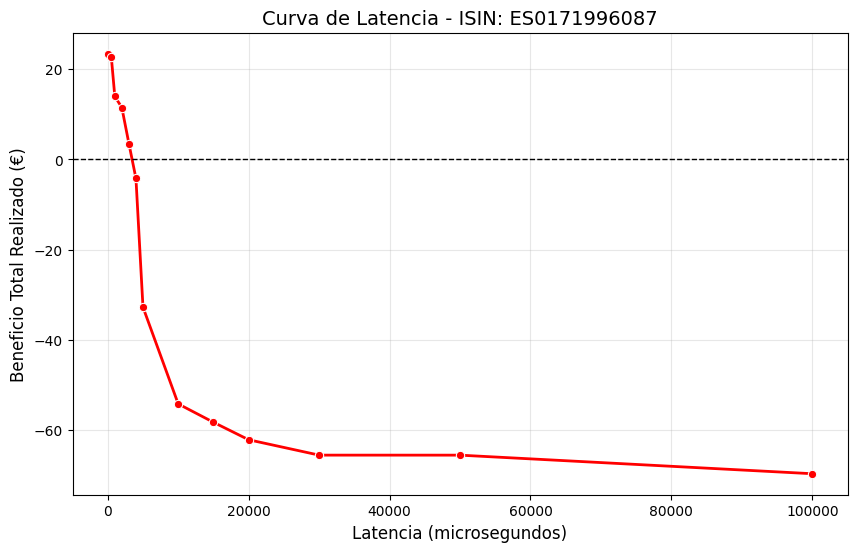

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definimos latencias a simular (en microsegundos)
LATENCIES = [0, 100, 500, 1000, 2000, 3000, 4000, 5000, 
             10000, 15000, 20000, 30000, 50000, 100000]

def simulate_latency_detailed(opportunities, full_tape, latencies_us):
    results = []
    print(f"Simulando {len(latencies_us)} escenarios de latencia...")
    
    for lat in latencies_us:
        # Definimos el tiempo de ejecución (Llegada al mercado = T + Latencia)
        execution_times = opportunities.index + lat
        
        # Buscar índices futuros en el tape (Searchsorted es vectorizado y muy rápido)
        # Nos dice en qué fila del tape cae nuestro tiempo de ejecución (ej: 100+50 estará entre 100 y 200)
        exec_indices = full_tape.index.searchsorted(execution_times)
        
        # Corregimos índices que se salgan del final (usamos el último dato conocido)
        exec_indices = np.clip(exec_indices, 0, len(full_tape) - 1)
        
        # Recuperar precios reales en el futuro
        realized_profits = []
        
        # Iteramos sobre las oportunidades para comparar precio teórico vs real
        for i, (idx, row) in enumerate(opportunities.iterrows()):
            tape_idx = exec_indices[i]
            future_row = full_tape.iloc[tape_idx]
            
            # Construimos los nombres de las columnas donde vamos a operar
            # Si la señal era vender en BME, buscamos el precio 'BME_px_bid_0' en el futuro
            bid_venue_col = f"{row['best_bid_venue']}_px_bid_0"
            ask_venue_col = f"{row['best_ask_venue']}_px_ask_0"
            
            # Leemos los precios futuros
            realized_bid = future_row[bid_venue_col]
            realized_ask = future_row[ask_venue_col]
            
            # Calculamos el P&L Realizado
            # Spread Real = Precio al que vendo realmente - Precio al que compro realmente
            spread_real = realized_bid - realized_ask
            
            # Beneficio = Spread Real * Volumen que habíamos calculado
            pnl = spread_real * row['qty_tradeable']
            realized_profits.append(pnl)
            
        # Sumamos todo el dinero ganado (o perdido) con esta latencia
        total_profit = sum(realized_profits)
        results.append({'Latency_us': lat, 'Total_Profit_EUR': total_profit})

    return pd.DataFrame(results)

# --- EJECUCIÓN ---
try:
    if 'opps' in locals() and not opps.empty:
        # Ejecutamos la simulación
        df_results = simulate_latency_detailed(opps, consolidated_tape, LATENCIES)
        
        # Mostramos la tabla de resultados
        print("\n--- Beneficio vs Latencia ---")
        display(df_results)
        
        # Mostramos un gráfico de como van variando los beneficios según aumenta la latencia
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_results, x='Latency_us', y='Total_Profit_EUR', marker='o', color='red', linewidth=2)
        
        plt.title(f"Curva de Latencia - ISIN: {TEST_ISIN}", fontsize=14)
        plt.xlabel("Latencia (microsegundos)", fontsize=12)
        plt.ylabel("Beneficio Total Realizado (€)", fontsize=12)
        
        # Añadimos una línea negra en el 0 para ver cuándo entramos en pérdidas
        plt.axhline(0, color='black', linestyle='--', linewidth=1) 
        plt.grid(True, alpha=0.3)
        plt.show()
        
    else:
        print("No hay oportunidades para simular. Ejecuta la Fase 3 primero.")
        
except Exception as e:
    print(f"Error en simulación: {e}")

### Escaneado de Mercado y Ranking Final (Scaling Up)

Tras validar la robustez de nuestro algoritmo con un activo de control (GRIFOLS), procedemos a la fase de industrialización. En esta etapa, el código iterará sobre la totalidad del dataset `DATA_BIG` para identificar las mejores oportunidades de arbitraje en todo el mercado.

Hemos optado por procesar los activos uno a uno (bucle iterativo) en lugar de una carga masiva por tres razones técnicas fundamentales:

1.  **Validación de Lógica:** El desarrollo previo sobre un "Case Study" garantiza que la limpieza de datos, la sincronización del Consolidated Tape y los cálculos de P&L son financieramente correctos antes de automatizar el proceso.
2.  **Gestión de Recursos (RAM):** Los datos de alta frecuencia (tick-by-tick) son masivos. Intentar cargar los 195 activos simultáneamente desbordaría la memoria RAM de mi ordenador. La estrategia óptima es cargar un ISIN, procesarlo, guardar sus métricas y liberar la memoria antes de pasar al siguiente.
3.  **Depuración Ágil:** Esta aproximación permite aislar excepciones (como archivos corruptos o activos sin liquidez) sin detener la ejecución global, facilitando una depuración ágil.

**Objetivo Final:**

Ejecutar el motor de arbitraje sobre todos los ficheros disponibles para generar el Ranking Top 5 exigido en el enunciado, identificando qué activos ofrecieron la mayor rentabilidad teórica bajo las condiciones de mercado analizadas.

In [22]:
import glob
import os
import pandas as pd

# Buscamos todos los ISINs únicos en DATA_BIG
print(f"Escaneando carpeta: {os.path.abspath(DATA_PATH)}...")

# Buscamos recursivamente todos los ficheros QTE
files = glob.glob(os.path.join(DATA_PATH, "**", "QTE_*.csv.gz"), recursive=True)

unique_isins = set()
for f in files:
    try:
        # El formato es: ...QTE_FECHA_ISIN_TICKER_MIC...
        # Ejemplo: QTE_2025-11-07_ES0171996087_GRF_XMAD_1.csv.gz
        parts = os.path.basename(f).split('_')
        if len(parts) > 3:
            unique_isins.add(parts[2]) # El ISIN es la 3ª parte
    except:
        continue

print(f"Se han encontrado {len(unique_isins)} activos distintos para analizar.")

# Bucle de Procesamiento
leaderboard = []

print("\nINICIANDO ANÁLISIS DE MERCADO COMPLETO...")

for i, isin in enumerate(unique_isins):
    print(f"[{i+1}/{len(unique_isins)}] Analizando {isin}...", end=" ")
    
    try:
        # A) Cargar Datos
        # Llamamos a la función que creamos
        df_loop = load_all_venues_for_isin(DATA_PATH, TEST_DATE, isin)
        
        # Si la función no encuentra datos (un DataFrame vacío), pasa a la siguiente acción
        if df_loop.empty:
            print("(Sin datos suficientes)")
            continue
            
        # Creamos Tape con la función creada
        tape_loop = build_consolidated_tape(df_loop)
        if tape_loop.empty:
            print("(Tape vacío)")
            continue
            
        # Buscamos oportunidades (Latencia 0)
        ops_loop = find_arbitrage_opportunities(tape_loop)
        
        # Suma y guarda todos los euros que podríamos haber ganado con esa acción en todo el día
        if not ops_loop.empty:
            total_profit = ops_loop['profit_theoretical'].sum()
            num_ops = len(ops_loop)
            
            leaderboard.append({
                'ISIN': isin,
                'Profit_EUR': round(total_profit, 2),
                'Num_Ops': num_ops
            })
            print(f"Profit: {total_profit:.2f} €")
        else:
            print("(Sin arbitraje)")
            
    except Exception as e:
        print(f"Error: {e}")

# 3. Mostrar el Ranking
print("\n" + "="*50)
print("RANKING FINAL: TOP OPORTUNIDADES (Latencia 0)")
print("="*50)

if leaderboard:
    df_ranking = pd.DataFrame(leaderboard)
    # Ordenamos por beneficio descendente
    df_ranking = df_ranking.sort_values('Profit_EUR', ascending=False).reset_index(drop=True)
    
    display(df_ranking.head(10)) # Mostramos Top 10 por si acaso
    
    # Exportamos a CSV
    df_ranking.to_csv("top_opportunities_ranking.csv", index=False)
    print("\nRanking guardado en 'top_opportunities_ranking.csv'")
else:
    print("No se encontraron oportunidades en ningún activo.")

Escaneando carpeta: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG...
Se han encontrado 195 activos distintos para analizar.

INICIANDO ANÁLISIS DE MERCADO COMPLETO...
[1/195] Analizando FR0011042753... Iniciando carga para FR0011042753 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 62426 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ✅ CBOE: Cargados 14060 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 4.20 €
[2/195] Analizando ES0105618005... Iniciando carga para ES0105618005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[3/195] Analizando ES0109427734... Iniciando carga para ES0109427734 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2877 ticks.
  ✅ AQUIS: Cargados 1846 ticks.
  ✅ CBOE: Cargados 2166 ticks.
  ✅ TURQUOISE: Cargados 1215 ticks.
(Sin arbitraje)
[4/195] Analizando FR0010251744... Iniciando carga para FR0010251744 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Va

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 1971 ticks.
  ✅ AQUIS: Cargados 1646 ticks.
  ✅ CBOE: Cargados 1810 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 0.00 €
[8/195] Analizando DE000SX50XC2... Iniciando carga para DE000SX50XC2 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 805 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[9/195] Analizando ES0105589008... Iniciando carga para ES0105589008 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin da

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 20594 ticks.
  ✅ AQUIS: Cargados 5986 ticks.
  ✅ CBOE: Cargados 9499 ticks.
  ✅ TURQUOISE: Cargados 3088 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 4.80 €
[12/195] Analizando NLBNPES1OQE5... Iniciando carga para NLBNPES1OQE5 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 910 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[13/195] Analizando ES0105229001... Iniciando carga para ES0105229001 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2059 ticks.
  ✅ AQUIS: Cargados 3657 ticks.
  ✅ CBOE: Cargados 2362 ticks.
  ✅ TURQUOISE: Cargados 4508 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 0.63 €
[14/195] Analizando ES0105725008... Iniciando carga para ES0105725008 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[15/195] Analizando ES0109067019... Iniciando carga para ES0109067019 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 81746 ticks.
  ✅ AQUIS: Cargados 45195 ticks.
  ✅ CBOE: Cargados 46613 ticks.
  ✅ TURQUOISE: Cargados 34358 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 161.86 €
[16/195] Analizando ES0105046017... Iniciando carga para ES0105046017 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 55621 ticks.
  ✅ AQUIS: Cargados 11097 ticks.
  ✅ CBOE: Cargados 23479 ticks.
  ✅ TURQUOISE: Cargados 13202 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 10.31 €
[17/195] Analizando ES0169501022... Iniciando carga para ES0169501022 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 9486 ticks.
  ✅ AQUIS: Cargados 7416 ticks.
  ✅ CBOE: Cargados 9977 ticks.
  ✅ TURQUOISE: Cargados 2999 ticks.
Profit: 9.50 €
[18/195] Analizando ES0116920333... Iniciando carga para ES0116920333 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 433 ticks.
  ✅ AQUIS: Cargados 160 ticks.
  ✅ CBOE: Cargados 458 ticks.
  ✅ TURQUOISE: Cargados 557 ticks.
(Sin arbitraje)
[19/195] Analizando BRPETRACNOR9... Iniciando carga para BRPETRACNOR9 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 110 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[22/195] Analizando DE000FD1Q5F6... Iniciando carga para DE000FD1Q5F6 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 439 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[23/195] Analizando DE000FD1Q0S0... Iniciando carga para DE000FD1Q0S0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 248 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos vál

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ AQUIS: Cargados 4210 ticks.
  ✅ CBOE: Cargados 5560 ticks.
  ✅ TURQUOISE: Cargados 523 ticks.
Profit: 71.20 €
[30/195] Analizando DE000SX0AP91... Iniciando carga para DE000SX0AP91 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 77 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[31/195] Analizando NLBNPES1DMO6... Iniciando carga para NLBNPES1DMO6 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 5065 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 5.00 €
[32/195] Analizando ES0105777017... Iniciando

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 36061 ticks.
  ✅ AQUIS: Cargados 19261 ticks.
  ✅ CBOE: Cargados 20278 ticks.
  ✅ TURQUOISE: Cargados 10408 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 5.84 €
[33/195] Analizando ES0180907000... Iniciando carga para ES0180907000 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 51052 ticks.
  ✅ AQUIS: Cargados 24086 ticks.
  ✅ CBOE: Cargados 23082 ticks.
  ✅ TURQUOISE: Cargados 12213 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 4.53 €
[34/195] Analizando ES0158867038... Iniciando carga para ES0158867038 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[35/195] Analizando ES0116561038... Iniciando carga para ES0116561038 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[36/195] Analizando ES0105509006... Iniciando carga para ES0105509006 en 2025-11-07...
Ruta base: c:\

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 240.05 €
[39/195] Analizando DE000FD1QYE5... Iniciando carga para DE000FD1QYE5 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 449 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[40/195] Analizando ES0125220311... Iniciando carga para ES0125220311 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 53779 ticks.
  ✅ AQUIS: Cargados 25007 ticks.
  ✅ CBOE: Cargados 22951 ticks.
  ✅ TURQUOISE: Cargados 14103 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 4.20 €
[41/195] Analizando DE000FD1QZP8... Iniciando carga para DE000FD1QZP8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 76 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[42/195] Analizando ES0178165017... Iniciando carga para ES0178165017 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 15999 ticks.
  ✅ AQUIS: Cargados 19425 ticks.
  ✅ CBOE: Cargados 18112 ticks.
  ✅ TURQUOISE: Cargados 14492 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 33.10 €
[43/195] Analizando DE000FD1Q005... Iniciando carga para DE000FD1Q005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1387 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[44/195] Analizando ES0180850416... Iniciando carga para ES0180850416 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 5132 ticks.
  ✅ AQUIS: Cargados 5561 ticks.
  ✅ CBOE: Cargados 6722 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 1.88 €
[45/195] Analizando ES0169350016... Iniciando carga para ES0169350016 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variabl

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 5861 ticks.
  ✅ AQUIS: Cargados 3429 ticks.
  ✅ CBOE: Cargados 5915 ticks.
  ✅ TURQUOISE: Cargados 2199 ticks.
Profit: 2.28 €
[48/195] Analizando ES0140609019... Iniciando carga para ES0140609019 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 158704 ticks.
  ✅ AQUIS: Cargados 58208 ticks.
  ✅ CBOE: Cargados 48486 ticks.
  ✅ TURQUOISE: Cargados 46582 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 21.43 €
[49/195] Analizando ES0105102000... Iniciando carga para ES0105102000 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[50/195] Analizando DE000SQ6DV56... Iniciando carga para DE000SQ6DV56 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 690 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[51/195] Analizando ES0116870314... Iniciando carga para ES0116870314 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[53/195] Analizando ES0170884417... Iniciando carga para ES0170884417 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 179 ticks.
  ✅ AQUIS: Cargados 63 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[54/195] Analizando ES0105130001... Iniciando carga para ES0105130001 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2944 ticks.
  ✅ AQUIS: Cargados 1823 ticks.
  ✅ CBOE: Cargados 2024 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 4.30 €
[55/195] Analizando ES0105336038... Iniciando carga para ES0105336038 en 2025-11-07...
Ru

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 38019 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[56/195] Analizando DE000FD1QY41... Iniciando carga para DE000FD1QY41 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 247 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[57/195] Analizando ES0167050915... Iniciando carga para ES0167050915 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 63605 ticks.
  ✅ AQUIS: Cargados 16157 ticks.
  ✅ CBOE: Cargados 24579 ticks.
  ✅ TURQUOISE: Cargados 14296 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 3.90 €
[58/195] Analizando ES0105251005... Iniciando carga para ES0105251005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3248 ticks.
  ✅ AQUIS: Cargados 1661 ticks.
  ✅ CBOE: Cargados 2205 ticks.
  ✅ TURQUOISE: Cargados 1894 ticks.
(Sin arbitraje)
[59/195] Analizando ES0130670112... Iniciando carga para ES0130670112 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 59274 ticks.
  ✅ AQUIS: Cargados 26658 ticks.
  ✅ CBOE: Cargados 25727 ticks.
  ✅ TURQUOISE: Cargados 18384 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 2.62 €
[60/195] Analizando ES0184262212... Iniciando carga para ES0184262212 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 4005 ticks.
  ✅ AQUIS: Cargados 3524 ticks.
  ✅ CBOE: Cargados 5934 ticks.
  ✅ TURQUOISE: Cargados 3098 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 38.30 €
[61/195] Analizando ES0105691002... Iniciando carga para ES0105691002 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[62/195] Analizando NLBNPES1BNU5... Iniciando carga para NLBNPES1BNU5 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 6989 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[63/195] Analizando BRPETRACNPR6... Iniciando carga para BRPETRACNPR6 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 233.75 €
[65/195] Analizando ES0105563003... Iniciando carga para ES0105563003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 30362 ticks.
  ✅ AQUIS: Cargados 10356 ticks.
  ✅ CBOE: Cargados 7865 ticks.
  ✅ TURQUOISE: Cargados 3968 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 3.98 €
[66/195] Analizando ES0157097017... Iniciando carga para ES0157097017 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3368 ticks.
  ✅ AQUIS: Cargados 2983 ticks.
  ✅ CBOE: Cargados 3400 ticks.
  ✅ TURQUOISE: Cargados 3057 ticks.
Profit: 0.16 €
[67/195] Analizando DE000FA5HCF1... Iniciando carga para DE000FA5HCF1 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 652 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


(Sin arbitraje)
[68/195] Analizando BRBBDCACNPR8... Iniciando carga para BRBBDCACNPR8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[69/195] Analizando ES0150480194... Iniciando carga para ES0150480194 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1490 ticks.
  ✅ AQUIS: Cargados 1500 ticks.
  ✅ CBOE: Cargados 364 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[70/195] Analizando ES0121975009... Iniciando carga para ES0121975009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Fi

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 8061 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[78/195] Analizando ES0105848008... Iniciando carga para ES0105848008 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 386 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ✅ CBOE: Cargados 253 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[79/195] Analizando NLBNPES1QNP3... Iniciando carga para NLBNPES1QNP3 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 11011 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 11047 ticks.
  ✅ AQUIS: Cargados 2957 ticks.
  ✅ CBOE: Cargados 5252 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[82/195] Analizando ARP125991090... Iniciando carga para ARP125991090 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[83/195] Analizando ES0105717005... Iniciando carga para ES0105717005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontrar

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


(Sin arbitraje)
[85/195] Analizando ES0180918015... Iniciando carga para ES0180918015 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2398 ticks.
  ✅ AQUIS: Cargados 1803 ticks.
  ✅ CBOE: Cargados 2084 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 13.96 €
[86/195] Analizando ES0134950F36... Iniciando carga para ES0134950F36 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3149 ticks.
  ✅ AQUIS: Cargados 3381 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ CBOE: Cargados 3614 ticks.
  ✅ TURQUOISE: Cargados 3074 ticks.
Profit: 1.35 €
[87/195] Analizando ES0105548004... Iniciando carga para ES0105548004 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 125 ticks.
  ✅ AQUIS: Cargados 45 ticks.
  ✅ CBOE: Cargados 118 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 1.50 €
[88/195] Analizando ES0173093024... Iniciando carga para ES0173093024 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 35452 ticks.
  ✅ AQUIS: Cargados 16170 ticks.
  ✅ CBOE: Cargados 21526 ticks.
  ✅ TURQUOISE: Cargados 13515 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 6.46 €
[89/195] Analizando ES0125140A14... Iniciando carga para ES0125140A14 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 475 ticks.
  ✅ AQUIS: Cargados 222 ticks.
  ✅ CBOE: Cargados 291 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[90/195] Analizando ES0105065009... Iniciando carga para ES0105065009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 5337 ticks.
  ✅ AQUIS: Cargados 4282 ticks.
  ✅ CBOE: Cargados 4575 ticks.
  ✅ TURQUOISE: Cargados 4645 ticks.
Profit: 413.28 €
[91/195] Analizando ES0113211835... Iniciando carga para ES0113211835 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_Dani

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 191748 ticks.
  ✅ AQUIS: Cargados 44608 ticks.
  ✅ CBOE: Cargados 71980 ticks.
  ✅ TURQUOISE: Cargados 25345 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 390.52 €
[92/195] Analizando ES0165386014... Iniciando carga para ES0165386014 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 69382 ticks.
  ✅ AQUIS: Cargados 40049 ticks.
  ✅ CBOE: Cargados 25288 ticks.
  ✅ TURQUOISE: Cargados 17489 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 43.24 €
[93/195] Analizando AU000000BKY0... Iniciando carga para AU000000BKY0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1127 ticks.
  ✅ AQUIS: Cargados 1132 ticks.
  ✅ CBOE: Cargados 926 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


(Sin arbitraje)
[94/195] Analizando ES0124244E34... Iniciando carga para ES0124244E34 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 43220 ticks.
  ✅ AQUIS: Cargados 14925 ticks.
  ✅ CBOE: Cargados 14155 ticks.
  ✅ TURQUOISE: Cargados 9113 ticks.
Profit: 0.45 €
[95/195] Analizando DE000FD1Q4T0... Iniciando carga para DE000FD1Q4T0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 462 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[96/195] Analizando ES0122060314... Iniciando carga para ES0122060314 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 3228 ticks.
  ✅ AQUIS: Cargados 1599 ticks.
  ✅ CBOE: Cargados 1958 ticks.
  ✅ TURQUOISE: Cargados 1242 ticks.
(Sin arbitraje)
[97/195] Analizando NLBNPES1ITH4... Iniciando carga para NLBNPES1ITH4 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 4348 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[98/195] Analizando ES0175438003... Iniciando carga para ES0175438003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2377 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ AQUIS: Cargados 1162 ticks.
  ✅ CBOE: Cargados 1530 ticks.
  ✅ TURQUOISE: Cargados 1167 ticks.
Profit: 1.66 €
[99/195] Analizando ES0137998A12... Iniciando carga para ES0137998A12 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 282 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[100/195] Analizando LU0569974404... Iniciando carga para LU0569974404 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 10084 ticks.
  ✅ AQUIS: Cargados 12537 ticks.
  ✅ CBOE: Cargados 17017 ticks.
  ✅ TURQUOISE: Cargados 17617 ticks.
Profit: 1.36 €
[101/195] Analizando ES0109260531... Iniciando carga para ES0109260531 en 2

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ CBOE: Cargados 2552 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[102/195] Analizando LU1048328220... Iniciando carga para LU1048328220 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2946 ticks.
  ✅ AQUIS: Cargados 1424 ticks.
  ✅ CBOE: Cargados 1948 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 31.96 €
[103/195] Analizando ES0113679I37... Iniciando carga para ES0113679I37 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 95043 ticks.
  ✅ AQUIS: Cargados 39216 ticks.
  ✅ CBOE: Cargados 31734 ticks.
  ✅ TURQUOISE: Cargados 20683 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 2.36 €
[104/195] Analizando ES0105836003... Iniciando carga para ES0105836003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 624 ticks.
  ✅ AQUIS: Cargados 284 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[105/195] Analizando ES0105321030... Iniciando carga para ES0105321030 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 28220 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[106/195] Analizando ES06837469D8... Iniciando carga para ES06837469D8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ CBOE: Cargados 3715 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 0.75 €
[108/195] Analizando ES0176252718... Iniciando carga para ES0176252718 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 5940 ticks.
  ✅ AQUIS: Cargados 2729 ticks.
  ✅ CBOE: Cargados 5510 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ TURQUOISE: Cargados 2285 ticks.
Profit: 0.58 €
[109/195] Analizando ES0183304080... Iniciando carga para ES0183304080 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1130 ticks.
  ✅ AQUIS: Cargados 1223 ticks.
  ✅ CBOE: Cargados 8 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 17.03 €
[110/195] Analizando ES0173365018... Iniciando carga para ES0173365018 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 144 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[111/195] Analizando ES0110047919... Iniciando carga para ES0110047919 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BM

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[114/195] Analizando ES0167733015... Iniciando carga para ES0167733015 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3273 ticks.
  ✅ AQUIS: Cargados 2943 ticks.
  ✅ CBOE: Cargados 3919 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[115/195] Analizando ES0157261019... Iniciando carga para ES0157261019 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 18755 ticks.
  ✅ AQUIS: Cargados 8841 ticks.
  ✅ CBOE: Cargados 5523 ticks.
  ✅ TURQUOISE: Cargados 2833 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 13.10 €
[116/195] Analizando FR0011036268... Iniciando carga para FR0011036268 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 32602 ticks.
  ✅ AQUIS: Cargados 7908 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 93.24 €
[117/195] Analizando ES0141571192... Iniciando carga para ES0141571192 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 330 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[118/195] Analizando ES0105857009... Iniciando carga para ES0105857009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanz

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 81940 ticks.
  ✅ AQUIS: Cargados 40999 ticks.
  ✅ CBOE: Cargados 42264 ticks.
  ✅ TURQUOISE: Cargados 20977 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Profit: 35.03 €
[121/195] Analizando ES0105148003... Iniciando carga para ES0105148003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1110 ticks.
  ✅ AQUIS: Cargados 833 ticks.
  ✅ CBOE: Cargados 803 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[122/195] Analizando ES0105225009... Iniciando carga para ES0105225009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[123/195] Analizando ES0114820113... Iniciando carga para ES0114820113 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - 

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 60432 ticks.
  ✅ AQUIS: Cargados 22435 ticks.
  ✅ CBOE: Cargados 19463 ticks.
  ✅ TURQUOISE: Cargados 22027 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Profit: 8.55 €
[129/195] Analizando ES0171743901... Iniciando carga para ES0171743901 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 93 ticks.
  ✅ AQUIS: Cargados 50 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[130/195] Analizando DE000SQ6DV72... Iniciando carga para DE000SQ6DV72 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 19 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[131/195] Analizando ES0105621009... Iniciando carga para ES0105621009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Rent

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ CBOE: Cargados 1736 ticks.
  ✅ TURQUOISE: Cargados 1320 ticks.
Profit: 1.55 €
[138/195] Analizando ES0105027009... Iniciando carga para ES0105027009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 25423 ticks.
  ✅ AQUIS: Cargados 10835 ticks.
  ✅ CBOE: Cargados 13666 ticks.
  ✅ TURQUOISE: Cargados 7494 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


(Sin arbitraje)
[139/195] Analizando ES0184980003... Iniciando carga para ES0184980003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[140/195] Analizando ES0171996087... Iniciando carga para ES0171996087 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 44144 ticks.
  ✅ AQUIS: Cargados 17481 ticks.
  ✅ CBOE: Cargados 20912 ticks.
  ✅ TURQUOISE: Cargados 7435 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 23.45 €
[141/195] Analizando DE000FD1QUF0... Iniciando carga para DE000FD1QUF0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1175 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[142/195] Analizando ES0105716130... Iniciando carga para ES0105716130 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[143/195] Analizando ES0105093001... Iniciando carga para ES0105093001 en 2025-11-07...
Ruta base: c:\Users\danie\Desk

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 139005 ticks.
  ✅ AQUIS: Cargados 57215 ticks.
  ✅ CBOE: Cargados 42829 ticks.
  ✅ TURQUOISE: Cargados 28878 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 24.77 €
[147/195] Analizando ES0182870214... Iniciando carga para ES0182870214 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 42875 ticks.
  ✅ AQUIS: Cargados 15981 ticks.
  ✅ CBOE: Cargados 23279 ticks.
  ✅ TURQUOISE: Cargados 12129 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 71.50 €
[148/195] Analizando ES0142090317... Iniciando carga para ES0142090317 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 8032 ticks.
  ✅ AQUIS: Cargados 4376 ticks.
  ✅ CBOE: Cargados 6873 ticks.
  ✅ TURQUOISE: Cargados 3249 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

(Sin arbitraje)
[149/195] Analizando ES0113312021... Iniciando carga para ES0113312021 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[150/195] Analizando NLBNPES1ZMK7... Iniciando carga para NLBNPES1ZMK7 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 606 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[151/195] Analizando ES0105884011... Iniciando carga para ES0105884011 en 2025-11-07...
Ruta base: c:\Users\danie\Deskt

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 44745 ticks.
  ✅ AQUIS: Cargados 16440 ticks.
  ✅ CBOE: Cargados 24958 ticks.
  ✅ TURQUOISE: Cargados 18235 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


(Sin arbitraje)
[155/195] Analizando ES0113860A34... Iniciando carga para ES0113860A34 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 130286 ticks.
  ✅ AQUIS: Cargados 55328 ticks.
  ✅ CBOE: Cargados 38637 ticks.
  ✅ TURQUOISE: Cargados 23610 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Profit: 15.64 €
[156/195] Analizando ES0126962069... Iniciando carga para ES0126962069 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1019 ticks.
  ✅ AQUIS: Cargados 483 ticks.
  ✅ CBOE: Cargados 790 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Profit: 1.06 €
[157/195] Analizando ES0105375002... Iniciando carga para ES0105375002 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 103 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ✅ CBOE: Cargados 170 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[158/195] Analizando ES0152768612... Iniciando carga para ES0152768612 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Pra

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 4096 ticks.
  ✅ AQUIS: Cargados 2711 ticks.
  ✅ CBOE: Cargados 3077 ticks.
  ✅ TURQUOISE: Cargados 1151 ticks.
Profit: 12.31 €
[162/195] Analizando ES0105029005... Iniciando carga para ES0105029005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[163/195] Analizando ES0118594417... Iniciando carga para ES0118594417 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 76529 ticks.
  ✅ AQUIS: Cargados 15350 ticks.
  ✅ CBOE: Cargados 26993 ticks.
  ✅ TURQUOISE: Cargados 7399 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 101.92 €
[164/195] Analizando ES0105025003... Iniciando carga para ES0105025003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 25084 ticks.
  ✅ AQUIS: Cargados 10655 ticks.
  ✅ CBOE: Cargados 12166 ticks.
  ✅ TURQUOISE: Cargados 6107 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


(Sin arbitraje)
[165/195] Analizando ES0172708234... Iniciando carga para ES0172708234 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 467 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[166/195] Analizando NL0015001FS8... Iniciando carga para NL0015001FS8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 83591 ticks.
  ✅ AQUIS: Cargados 31433 ticks.
  ✅ CBOE: Cargados 36845 ticks.
  ✅ TURQUOISE: Cargados 24311 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Profit: 19.98 €
[167/195] Analizando DE000FA5G8E7... Iniciando carga para DE000FA5G8E7 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 340 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[168/195] Analizando ES0164180012... Iniciando carga para ES0164180012 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1041 ticks.
  ✅ AQUIS: Cargados 1430 ticks.
  ✅ CBOE: Cargados 2324 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[169/195] Analizando ES0105517025... Iniciando carga para ES0105517025 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Vari

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 88510 ticks.
  ✅ AQUIS: Cargados 33110 ticks.
  ✅ CBOE: Cargados 42724 ticks.
  ✅ TURQUOISE: Cargados 26208 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 24.00 €
[173/195] Analizando ES0132105018... Iniciando carga para ES0132105018 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 34925 ticks.
  ✅ AQUIS: Cargados 13731 ticks.
  ✅ CBOE: Cargados 14381 ticks.
  ✅ TURQUOISE: Cargados 6054 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 16.58 €
[174/195] Analizando ES0105650008... Iniciando carga para ES0105650008 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[175/195] Analizando ES0105066007... Iniciando carga para ES0105066007 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 94164 ticks.
  ✅ AQUIS: Cargados 55498 ticks.
  ✅ CBOE: Cargados 61188 ticks.
  ✅ TURQUOISE: Cargados 41040 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Profit: 278.08 €
[176/195] Analizando MX01CO0U0028... Iniciando carga para MX01CO0U0028 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[177/195] Analizando ES0177542018... Iniciando carga para ES0177542018 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 407916 ticks.
  ✅ AQUIS: Cargados 195429 ticks.
  ✅ CBOE: Cargados 301449 ticks.
  ✅ TURQUOISE: Cargados 210666 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Profit: 793.90 €
[178/195] Analizando ES0158480311... Iniciando carga para ES0158480311 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 15 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[179/195] Analizando ES0115002018... Iniciando carga para ES0115002018 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 217 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[180/195] Analizando ES0173516115... Iniciando carga para ES0173516115 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Profit: 51.36 €
[181/195] Analizando DE000FD1Q3S4... Iniciando carga para DE000FD1Q3S4 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 780 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[182/195] Analizando ES0105702007... Iniciando carga para ES0105702007 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin datos suficientes)
[183/195] Analizando ES0105521001... Iniciando carga para ES0105521001 en 2025-11-07...
Ruta base: c:\Users\danie\Deskt

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 15506 ticks.
  ✅ AQUIS: Cargados 7013 ticks.
  ✅ CBOE: Cargados 8264 ticks.
  ✅ TURQUOISE: Cargados 4715 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

(Sin arbitraje)
[189/195] Analizando DE000FD1Q4U8... Iniciando carga para DE000FD1Q4U8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 608 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[190/195] Analizando DE000FA5HGL0... Iniciando carga para DE000FA5HGL0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1497 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[191/195] Analizando ES0126501131... Iniciando carga para ES0126501131 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Profit: 32.19 €
[193/195] Analizando ES0166300212... Iniciando carga para ES0166300212 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 491 ticks.
  ✅ AQUIS: Cargados 352 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[194/195] Analizando DE000FD1Q344... Iniciando carga para DE000FD1Q344 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 334 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
(Sin arbitraje)
[195/195] Analizando ES0183746314... Iniciando carga para ES0183746314 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


,ISIN,Profit_EUR,Num_Ops
0,ES0177542018,793.90,917
1,ES0105065009,413.28,5
2,ES0113211835,390.52,66
3,ES0105066007,278.08,95
4,ES0144580Y14,240.05,17
5,ES0113900J37,233.75,291
6,ES0109067019,161.86,97
7,DE000FD1Q0E0,103.48,2
8,ES0118594417,101.92,19
9,FR0011036268,93.24,23



Ranking guardado en 'top_opportunities_ranking.csv'


**¿Parecen reales los resultados?**

Sí, los resultados son realistas y coherentes. Podemos justificarlo de varias formas.

1. **Magnitud del beneficio:** Si el código no hubiera filtrado correctamente los "Magic Numbers", veríamos beneficios de millones de euros por operación. El hecho de que las cifras no sean tan disparatadas es un buen indicador.
2. **Selección de activos:** El ganador es IAG (ES0177542018) con 917 oportunidades. Esto es un buen indicador ya que IAG es una de las acciones más líquidas y fragmentadas del mercado. Cotiza intensamente en Madrid (BME) y Londres, lo que enera mucha actividad en plataformas alternativas como CBOE y Turquoise. Es el candidato perfecto para el arbitraje.
3. **Eficiencia del Mercado:** De los 195 activos analizados, muchos mostraron 0 € de beneficio o cantidades insignificantes (1-2 €). Esto demuestra que el mercado es normalmente eficiente. Si el algoritmo hubiera encontrado ganancias masivas en todas las acciones, sería sospechoso.

### Análisis Agregado de Mercado ("The Global Money Table")

El análisis anterior generó un ranking basado en el beneficio teórico a latencia 0. Sin embargo, para evaluar la viabilidad real de una estrategia de HFT a nivel de cartera, es necesario entender cómo reacciona el mercado en su conjunto ante la latencia.

Este bloque final responde al requerimiento específico del entregable: *"A summary table showing the Total Realized Profit for all processed ISINs at each latency level"*.

**Metodología:**
1.  **Re-procesamiento Masivo:** Se itera nuevamente sobre todos los activos detectados en el paso anterior.
2.  **Simulación Vectorizada:** Para cada activo con oportunidades, se ejecuta la función `simulate_latency_detailed` (validada anteriormente con el "Case Study").
3.  **Agregación:** Se suman los beneficios ($P\&L$) de todos los activos para cada nivel de latencia (0µs, 100µs... 100ms).

**Resultado Esperado:**
Obtendremos una visión macroscópica de la sensibilidad a la latencia. Si la curva agregada cae drásticamente (como se espera), confirmará que la rentabilidad del arbitraje en BME depende críticamente de la velocidad de ejecución, validando la hipótesis de *Adverse Selection* a nivel de mercado global.

INICIANDO CÁLCULO DE LA 'MONEY TABLE' AGREGADA...
   (Esto ejecutará la simulación de latencia para CADA activo activo)
   ... Procesando activo 1/195 ...
Iniciando carga para FR0011042753 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 62426 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ✅ CBOE: Cargados 14060 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0105618005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0109427734 en 2025-11-07...
Ruta base: c:

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 2877 ticks.
  ✅ AQUIS: Cargados 1846 ticks.
  ✅ CBOE: Cargados 2166 ticks.
  ✅ TURQUOISE: Cargados 1215 ticks.
Iniciando carga para FR0010251744 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 32693 ticks.
  ✅ AQUIS: Cargados 17402 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para NL0015001OI1 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 553 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para BRUSIMACNOR3 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0136463017 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ B

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105229001 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2059 ticks.
  ✅ AQUIS: Cargados 3657 ticks.
  ✅ CBOE: Cargados 2362 ticks.
  ✅ TURQUOISE: Cargados 4508 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0105725008 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0109067019 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Fin

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0105046017 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 55621 ticks.
  ✅ AQUIS: Cargados 11097 ticks.
  ✅ CBOE: Cargados 23479 ticks.
  ✅ TURQUOISE: Cargados 13202 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0169501022 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 9486 ticks.
  ✅ AQUIS: Cargados 7416 ticks.
  ✅ CBOE: Cargados 9977 ticks.
  ✅ TURQUOISE: Cargados 2999 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para ES0116920333 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 433 ticks.
  ✅ AQUIS: Cargados 160 ticks.
  ✅ CBOE: Cargados 458 ticks.
  ✅ TURQUOISE: Cargados 557 ticks.
Iniciando carga para BRPETRACNOR9 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0173358039 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 70 ticks.
  ❌ AQUIS: No se

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 36061 ticks.
  ✅ AQUIS: Cargados 19261 ticks.
  ✅ CBOE: Cargados 20278 ticks.
  ✅ TURQUOISE: Cargados 10408 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0180907000 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 51052 ticks.
  ✅ AQUIS: Cargados 24086 ticks.
  ✅ CBOE: Cargados 23082 ticks.
  ✅ TURQUOISE: Cargados 12213 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0158867038 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0116561038 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105509006 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\D

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para DE000FD1QYE5 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 449 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0125220311 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 53779 ticks.
  ✅ AQUIS: Cargados 25007 ticks.
  ✅ CBOE: Cargados 22951 ticks.
  ✅ TURQUOISE: Cargados 14103 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
   ... Procesando activo 41/195 ...
Iniciando carga para DE000FD1QZP8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 76 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0178165017 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 15999 ticks.
  ✅ AQUIS: Cargados 19425 ticks.
  ✅ CBOE: Cargados 18112 ticks.
  ✅ TURQUOISE: Cargados 14492 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para DE000FD1Q005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1387 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0180850416 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 5132 ticks.
  ✅ AQUIS: Cargados 5561 ticks.
  ✅ CBOE: Cargados 6722 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0169350016 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
 

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Iniciando carga para ES0105223004 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 5861 ticks.
  ✅ AQUIS: Cargados 3429 ticks.
  ✅ CBOE: Cargados 5915 ticks.
  ✅ TURQUOISE: Cargados 2199 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0140609019 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 158704 ticks.
  ✅ AQUIS: Cargados 58208 ticks.
  ✅ CBOE: Cargados 48486 ticks.
  ✅ TURQUOISE: Cargados 46582 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0105102000 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para DE000SQ6DV56 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 690 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
   ... Procesando activo 51/195 ...
Iniciando carga para ES0116870314 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarci

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 2944 ticks.
  ✅ AQUIS: Cargados 1823 ticks.
  ✅ CBOE: Cargados 2024 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0105336038 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 38019 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para DE000FD1QY41 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 247 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0167050915 en 2025-11-07...
Ruta base: c:\Users\danie\Des

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 63605 ticks.
  ✅ AQUIS: Cargados 16157 ticks.
  ✅ CBOE: Cargados 24579 ticks.
  ✅ TURQUOISE: Cargados 14296 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0105251005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3248 ticks.
  ✅ AQUIS: Cargados 1661 ticks.
  ✅ CBOE: Cargados 2205 ticks.
  ✅ TURQUOISE: Cargados 1894 ticks.
Iniciando carga para ES0130670112 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 59274 ticks.
  ✅ AQUIS: Cargados 26658 ticks.
  ✅ CBOE: Cargados 25727 ticks.
  ✅ TURQUOISE: Cargados 18384 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0184262212 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 4005 ticks.
  ✅ AQUIS: Cargados 3524 ticks.
  ✅ CBOE: Cargados 5934 ticks.
  ✅ TURQUOISE: Cargados 3098 ticks.
Simulando 14 escenarios de latencia...
   ... Procesando activo 61/195 ...
Iniciando carga para ES0105691002 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para NLBNPES1BNU5 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielG

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Iniciando carga para BRPETRACNPR6 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0113900J37 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 362896 ticks.
  ✅ AQUIS: Cargados 101560 ticks.
  ✅ CBOE: Cargados 78375 ticks.
  ✅ TURQUOISE: Cargados 43325 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0105563003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 30362 ticks.
  ✅ AQUIS: Cargados 10356 ticks.
  ✅ CBOE: Cargados 7865 ticks.
  ✅ TURQUOISE: Cargados 3968 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para ES0157097017 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3368 ticks.
  ✅ AQUIS: Cargados 2983 ticks.
  ✅ CBOE: Cargados 3400 ticks.
  ✅ TURQUOISE: Cargados 3057 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para DE000FA5HCF1 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 652 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para BRBBDCACNPR8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Iniciando carga para ES0105463006 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0175589029 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para NLBNPES1Q3T8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 8061 ticks.
 

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 11047 ticks.
  ✅ AQUIS: Cargados 2957 ticks.
  ✅ CBOE: Cargados 5252 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ARP125991090 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105717005 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105122024 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BM

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para ES0134950F36 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3149 ticks.
  ✅ AQUIS: Cargados 3381 ticks.
  ✅ CBOE: Cargados 3614 ticks.
  ✅ TURQUOISE: Cargados 3074 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0105548004 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 125 ticks.
  ✅ AQUIS: Cargados 45 ticks.
  ✅ CBOE: Cargados 118 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0173093024 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 35452 ticks.
  ✅ AQUIS: Cargados 16170 ticks.
  ✅ CBOE: Cargados 21526 ticks.
  ✅ TURQUOISE: Cargados 13515 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0125140A14 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 475 ticks.
  ✅ AQUIS: Cargados 222 ticks.
  ✅ CBOE: Cargados 291 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105065009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 5337 ticks.
  ✅ AQUIS: Cargados 4282 ticks.
  ✅ CBOE: Cargados 4575 ticks.
  ✅ TURQUOISE: Cargados 4645 ticks.
Simulando 14 escenarios de latencia...
   ... Procesando activo 91/195 ...
Iniciando carga para ES0113211835 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 191748 ticks.
  ✅ AQUIS: Cargados 44608 ticks.
  ✅ CBOE: Cargados 71980 ticks.
  ✅ TURQUOISE: Cargados 25345 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0165386014 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 69382 ticks.
  ✅ AQUIS: Cargados 40049 ticks.
  ✅ CBOE: Cargados 25288 ticks.
  ✅ TURQUOISE: Cargados 17489 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para AU000000BKY0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1127 ticks.
  ✅ AQUIS: Cargados 1132 ticks.
  ✅ CBOE: Cargados 926 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0124244E34 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 43220 ticks.
  ✅ AQUIS: Cargados 14925 ticks.
  ✅ CBOE: Cargados 14155 ticks.
  ✅ TURQUOISE: Cargados 9113 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para DE000FD1Q4T0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 462 ticks.
  ❌ AQ

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Iniciando carga para ES0122060314 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3228 ticks.
  ✅ AQUIS: Cargados 1599 ticks.
  ✅ CBOE: Cargados 1958 ticks.
  ✅ TURQUOISE: Cargados 1242 ticks.
Iniciando carga para NLBNPES1ITH4 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 4348 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0175438003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2377 ticks.
  ✅ AQUIS: Cargados 1162 ticks.
  ✅ CBOE: Cargados 1530 ticks

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 282 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para LU0569974404 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 10084 ticks.
  ✅ AQUIS: Cargados 12537 ticks.
  ✅ CBOE: Cargados 17017 ticks.
  ✅ TURQUOISE: Cargados 17617 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
   ... Procesando activo 101/195 ...
Iniciando carga para ES0109260531 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2861 ticks.
  ✅ AQUIS: Cargados 1447 ticks.
  ✅ CBOE: Cargados 2552 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para LU1048328220 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 2946 ticks.
  ✅ AQUIS: Cargados 1424 ticks.
  ✅ CBOE: Cargados 1948 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0113679I37 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\da

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0105836003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 624 ticks.
  ✅ AQUIS: Cargados 284 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105321030 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 28220 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Iniciando carga para ES06837469D8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 3474 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0129743318 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 4539 ticks.
  ✅ AQUIS: Cargados 2538 ticks.
  ✅ CBOE: Cargados 3715 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0176252718 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 5940 ticks.
  ✅ AQUIS:

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 3273 ticks.
  ✅ AQUIS: Cargados 2943 ticks.
  ✅ CBOE: Cargados 3919 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0157261019 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 18755 ticks.
  ✅ AQUIS: Cargados 8841 ticks.
  ✅ CBOE: Cargados 5523 ticks.
  ✅ TURQUOISE: Cargados 2833 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para FR0011036268 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 32602 ticks.
  ✅ AQUIS: Cargados 7908 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0141571192 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 330 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105857009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105709002 en 2025-11-07...
Ruta 

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 81940 ticks.
  ✅ AQUIS: Cargados 40999 ticks.
  ✅ CBOE: Cargados 42264 ticks.
  ✅ TURQUOISE: Cargados 20977 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
   ... Procesando activo 121/195 ...
Iniciando carga para ES0105148003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1110 ticks.
  ✅ AQUIS: Cargados 833 ticks.
  ✅ CBOE: Cargados 803 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105225009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0114820113 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DA

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 35 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para PEP648014202 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0119037010 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 615 ticks.
  ✅ AQUIS: Cargados 577 ticks.
  ✅ CBOE: Cargados 392 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0130960018 en 2025-11-07...
Ruta base: c:\Users\da

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para ES0171743901 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 93 ticks.
  ✅ AQUIS: Cargados 50 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para DE000SQ6DV72 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 19 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
   ... Procesando activo 131/195 ...
Iniciando carga para ES0105621009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_B

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0105630315 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1838 ticks.
  ✅ AQUIS: Cargados 1221 ticks.
  ✅ CBOE: Cargados 1736 ticks.
  ✅ TURQUOISE: Cargados 1320 ticks.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0105027009 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 25423 ticks.
  ✅ AQUIS: Cargados 10835 ticks.
  ✅ CBOE: Cargados 13666 ticks.
  ✅ TURQUOISE: Cargados 7494 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Iniciando carga para ES0184980003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0171996087 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 44144 ticks.
  ✅ AQUIS: Cargados 17481 ticks.
  ✅ CBOE: Cargados 20912 ticks.
  ✅ TURQUOISE: Cargados 7435 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
   ... Procesando activo 141/195 ...
Iniciando carga para DE000FD1QUF0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1175 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105716130 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105093001 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGar

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0182870214 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 42875 ticks.
  ✅ AQUIS: Cargados 15981 ticks.
  ✅ CBOE: Cargados 23279 ticks.
  ✅ TURQUOISE: Cargados 12129 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0142090317 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 8032 ticks.
  ✅ AQUIS: Cargados 4376 ticks.
  ✅ CBOE: Cargados 6873 ticks.
  ✅ TURQUOISE: Cargados 3249 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Iniciando carga para ES0113312021 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para NLBNPES1ZMK7 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 606 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
   ... Procesando activo 151/195 ...
Iniciando carga para ES0105884011 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para NL0000235190 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 44745 ticks.
  ✅ AQUIS: Cargados 16440 ticks.
  ✅ CBOE: Cargados 24958 ticks.
  ✅ TURQUOISE: Cargados 18235 ticks.
Iniciando carga para ES0113860A34 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 130286 ticks.
  ✅ AQUIS: Cargados 55328 ticks.
  ✅ CBOE: Cargados 38637 ticks.
  ✅ TURQUOISE: Cargados 23610 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para ES0126962069 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1019 ticks.
  ✅ AQUIS: Cargados 483 ticks.
  ✅ CBOE: Cargados 790 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Simulando 14 escenarios de latencia...
Iniciando carga para ES0105375002 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 103 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ✅ CBOE: Cargados 170 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0152768612 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 76529 ticks.
  ✅ AQUIS: Cargados 15350 ticks.
  ✅ CBOE: Cargados 26993 ticks.
  ✅ TURQUOISE: Cargados 7399 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0105025003 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 25084 ticks.
  ✅ AQUIS: Cargados 10655 ticks.
  ✅ CBOE: Cargados 12166 ticks.
  ✅ TURQUOISE: Cargados 6107 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Iniciando carga para ES0172708234 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 467 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para NL0015001FS8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 83591 ticks.
  ✅ AQUIS: Cargados 31433 ticks.
  ✅ CBOE: Cargados 36845 ticks.
  ✅ TURQUOISE: Cargados 24311 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para DE000FA5G8E7 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 340 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0164180012 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1041 ticks.
  ✅ AQUIS: Cargados 1430 ticks.
  ✅ CBOE: Cargados 2324 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105517025 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0132105018 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 34925 ticks.
  ✅ AQUIS: Cargados 13731 ticks.
  ✅ CBOE: Cargados 14381 ticks.
  ✅ TURQUOISE: Cargados 6054 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0105650008 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105066007 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 94164 ticks.
  ✅ AQUIS: Cargados 55498 ticks.
  ✅ CBOE: Cargados 61188 ticks.
  ✅ TURQUOISE: Cargados 41040 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para MX01CO0U0028 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0177542018 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 407916 ticks.
  ✅ AQUIS: Cargados 195429 ticks.
  ✅ CBOE: Cargados 301449 ticks.
  ✅ TURQUOISE: Cargados 210666 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


Simulando 14 escenarios de latencia...
Iniciando carga para ES0158480311 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 15 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0115002018 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 217 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0173516115 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


  ✅ BME: Cargados 91454 ticks.
  ✅ AQUIS: Cargados 21917 ticks.
  ✅ CBOE: Cargados 26134 ticks.
  ✅ TURQUOISE: Cargados 12848 ticks.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
   ... Procesando activo 181/195 ...
Iniciando carga para DE000FD1Q3S4 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 780 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105702007 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ❌ BME: No se encontraron datos válidos.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0105521001 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarc

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ CBOE: Cargados 8264 ticks.
  ✅ TURQUOISE: Cargados 4715 ticks.
Iniciando carga para DE000FD1Q4U8 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 608 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para DE000FA5HGL0 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 1497 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
   ... Procesando activo 191/195 ...
Iniciando carga para ES0126501131 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Var

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

  ✅ BME: Cargados 21526 ticks.
  ✅ AQUIS: Cargados 14795 ticks.
  ✅ CBOE: Cargados 19578 ticks.
  ❌ TURQUOISE: No se encontraron datos válidos.


C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Simulando 14 escenarios de latencia...
Iniciando carga para ES0166300212 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 491 ticks.
  ✅ AQUIS: Cargados 352 ticks.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para DE000FD1Q344 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 334 ticks.
  ❌ AQUIS: No se encontraron datos válidos.
  ❌ CBOE: No se encontraron datos válidos.
  ❌ TURQUOISE: No se encontraron datos válidos.
Iniciando carga para ES0183746314 en 2025-11-07...
Ruta base: c:\Users\danie\Desktop\MIAX - BME\Bloque 2 - Finanzas\Renta Variable\TAREA 3\Practica Renta Variable_DanielGarciaLopez_77856928L\data\DATA_BIG
  ✅ BME: Cargados 7245 ticks.
 

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2504409882.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tape['entry_signal'] = tape['is_arbitrage'] & (~tape['is_arbitrage'].shift(1).fillna(False))


,Latency_us,Total_Market_Profit_EUR
0,0,"3,589.80 €"
1,100,"2,729.57 €"
2,500,"2,428.19 €"
3,1000,"1,933.41 €"
4,2000,"1,412.83 €"
5,3000,795.37 €
6,4000,403.36 €
7,5000,-160.56 €
8,10000,"-1,670.85 €"
9,15000,"-2,198.22 €"


Gráfico guardado como 'global_latency_decay.png'


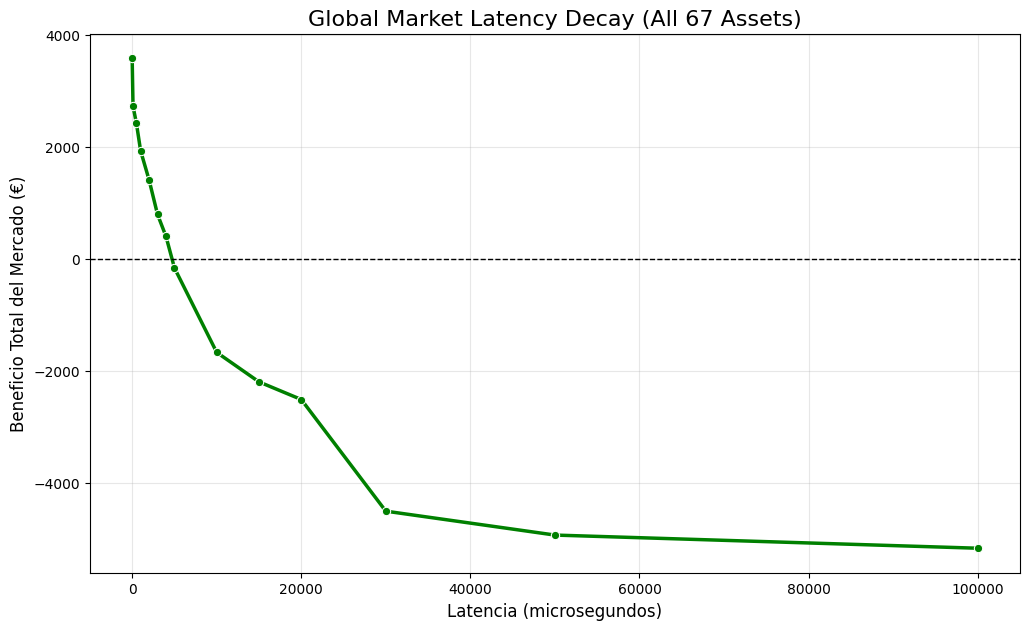

Tabla guardada como 'global_money_table.csv'


In [23]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configuramos latencias
LATENCIES = [0, 100, 500, 1000, 2000, 3000, 4000, 5000, 
             10000, 15000, 20000, 30000, 50000, 100000]

# Diccionario para acumular el beneficio de todos los activos en cada latencia
# Estructura: {0: 1500.50, 100: 1400.20, ...}
global_money_table = {lat: 0.0 for lat in LATENCIES}

print(f"INICIANDO CÁLCULO DE LA 'MONEY TABLE' AGREGADA...")
print(f"   (Esto ejecutará la simulación de latencia para CADA activo activo)")

processed_count = 0

for i, isin in enumerate(unique_isins):
    # Imprimimos progreso cada 10 activos para no saturar
    if i % 10 == 0:
        print(f"   ... Procesando activo {i+1}/{len(unique_isins)} ...")
    
    try:
        # Cargar
        df_loop = load_all_venues_for_isin(DATA_PATH, TEST_DATE, isin)
        if df_loop.empty: continue
            
        # Tape
        tape_loop = build_consolidated_tape(df_loop)
        if tape_loop.empty: continue
            
        # Señales
        ops_loop = find_arbitrage_opportunities(tape_loop)
        if ops_loop.empty: continue
        
        # SIMULACIÓN DE LATENCIA
        # Usamos la función simulate_latency_detailed
        # Nota: La función devuelve un DataFrame. Lo sumamos al total.
        df_sim = simulate_latency_detailed(ops_loop, tape_loop, LATENCIES)
        
        # Sumamos los resultados de este activo al acumulador global
        for index, row in df_sim.iterrows():
            lat = row['Latency_us']
            profit = row['Total_Profit_EUR']
            global_money_table[lat] += profit
            
        processed_count += 1
            
    except Exception as e:
        continue # Si falla uno, seguimos con el siguiente

# Generamos Tabla Final
print("\n" + "="*50)
print("GLOBAL MONEY TABLE (Mercado Completo)")
print("="*50)
print(f"Activos contribuyentes al beneficio: {processed_count}")

df_global_money = pd.DataFrame(list(global_money_table.items()), columns=['Latency_us', 'Total_Market_Profit_EUR'])

# Formato bonito
pd.options.display.float_format = '{:,.2f} €'.format
display(df_global_money)

# Gráfico Global
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_global_money, x='Latency_us', y='Total_Market_Profit_EUR', marker='o', color='green', linewidth=2.5)
plt.title(f"Global Market Latency Decay (All {processed_count} Assets)", fontsize=16)
plt.xlabel("Latencia (microsegundos)", fontsize=12)
plt.ylabel("Beneficio Total del Mercado (€)", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)
plt.savefig("global_latency_decay.png", dpi=300, bbox_inches='tight')
print("Gráfico guardado como 'global_latency_decay.png'")
plt.show()

# Guardar
df_global_money.to_csv("global_money_table.csv", index=False)
print("Tabla guardada como 'global_money_table.csv'")

Las pérdidas en latencias altas (>5ms) son consecuencia de la seleciión y la ejecución contra precios caducados. Al llegar tarde al mercado, nuestras órdenes solo se ejecutan cuando la oportunidad real ya ha desaparecido y el precio se ha movido en nuestra contra